In [78]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [79]:
sudoku = cv2.imread('data/sudoku_1.jpg')
sudoku = cv2.resize(sudoku,(282,282))
# plt.figure()
# plt.imshow(sudoku)
# plt.show()

In [80]:
gray = cv2.cvtColor(sudoku, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 1)
thresh = cv2.adaptiveThreshold(blur, maxValue=255, adaptiveMethod=1, thresholdType=1, blockSize=11, C=2)

In [81]:
# plt.title('Gaussian Blur')
# plt.imshow(blur)
# plt.show()
# plt.title('Adaptive Threshold')
# plt.imshow(thresh)
# plt.show()

In [82]:
sudoku_contour = sudoku.copy()
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sudoku_contour = cv2.drawContours(sudoku_contour, contours[1], -1, (0, 255, 0), 3)


In [83]:
# plt.title('Contours')
# plt.imshow(sudoku_contour)
# plt.show()

In [84]:
def bigContour(contours):
    big = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50: #if too small, will find noise
            perimeter = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02*perimeter, True)
            if area > max_area and len(approx)==4: #checking of rect/square
                big = approx
                max_area = area
    return big, max_area

In [85]:
# order of the 4 points should be the same always. reorder() ensures this
def reorder(points):
    points = points.reshape((4,2))
    points_new = np.zeros((4,1,2), dtype=np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] =  points[np.argmax(add)]
    diff = np.diff(points, axis=1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

In [86]:
sudoku_big_contour = sudoku.copy()
big, max_area = bigContour(contours[1])
if big.size!=0:
    big = reorder(big)
    sudoku_big_contour = cv2.drawContours(sudoku_big_contour, big, -1, (255,255,0), 20) #draw the biggest contour
    # preapres points for warp
    pts1 = np.float32(big) 
    pts2 = np.float32([[0,0], [252,0], [0,252], [252, 252]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    warped_sudoku = cv2.warpPerspective(sudoku, matrix, (252, 252))
    warped_sudoku = cv2.cvtColor(warped_sudoku, cv2.COLOR_RGB2GRAY)

In [89]:
warped_sudoku

array([[ 26,  18,   6, ...,   0,   4,  13],
       [ 18,  59, 102, ..., 125, 109,  69],
       [  6,  92, 176, ..., 219, 188, 110],
       ...,
       [  0, 106, 207, ..., 255, 219, 125],
       [  7,  88, 169, ..., 207, 177, 104],
       [ 18,  52,  88, ..., 106,  93,  59]], dtype=uint8)

In [61]:
# plt.title('Big Contour')
# plt.imshow(sudoku_big_contour)
# plt.title('Warped')
# plt.show()
# plt.imshow(warped_sudoku)
# plt.show()

In [62]:
def split_boxes(image):
    rows = np.vsplit(image, 9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r, 9)
        for box in cols:
            boxes.append(box)
    return boxes

In [76]:
# detected = sudoku.copy()


In [77]:
warped_sudoku

array([[ 26,  18,   6, ...,   0,   4,  13],
       [ 18,  59, 102, ..., 125, 109,  69],
       [  6,  92, 176, ..., 219, 188, 110],
       ...,
       [  0, 106, 207, ..., 255, 219, 125],
       [  7,  88, 169, ..., 207, 177, 104],
       [ 18,  52,  88, ..., 106,  93,  59]], dtype=uint8)

In [90]:
for i,img in enumerate(warped_sudoku):
    mean = np.mean(img)
    std = np.std(img)
    warped_sudoku[i] = (img-mean)/std
      

In [91]:
(warped_sudoku)

array([[  8,   5,   1, ...,   0,   1,   3],
       [249, 252, 255, ...,   0,   0, 253],
       [249, 252, 255, ...,   0,   0, 253],
       ...,
       [249, 252, 255, ...,   0,   0, 253],
       [249, 252, 255, ...,   0,   0, 253],
       [249, 252, 255, ...,   0,   0, 253]], dtype=uint8)

In [92]:
boxes = split_boxes(warped_sudoku)
for i in range(len(boxes)):
    for j in range(len(boxes[i])):
        boxes[i][j][0]=0
        boxes[i][j][-1]=0

In [93]:
nums = np.array([1 if np.sum(boxes[i].flatten())/(255*81)>0.5 else 0 for i in range(len(boxes))])

In [94]:
nums

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [21]:
np.sum(boxes[1].flatten())/(255*81)

0.07412248850157346

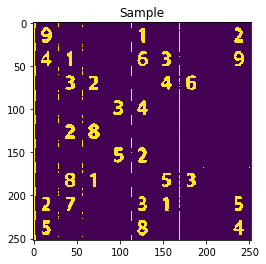

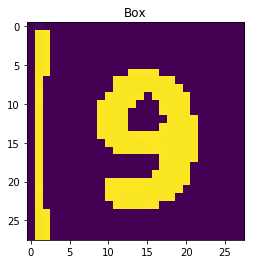

In [22]:
plt.title('Sample')
plt.imshow(warped_sudoku)
plt.show()
plt.title('Box')
plt.imshow(boxes[0])
plt.show()

In [95]:
np.shape(boxes)

(81, 28, 28)

In [24]:
from tensorflow import keras
from keras.models import load_model
model = load_model('model.h5')
boxes = np.reshape(boxes, (-1,28,28,1))
predicted_numbers = model.predict_classes(boxes)

C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passi

[[9 0 0 0 1 0 0 0 2]
 [4 1 0 0 6 3 0 0 9]
 [0 3 2 0 0 4 6 0 0]
 [0 0 0 3 4 0 0 0 0]
 [0 2 8 0 0 0 0 0 0]
 [0 0 0 5 2 0 0 0 0]
 [0 8 1 0 0 5 3 0 0]
 [2 7 0 0 3 1 0 0 5]
 [5 0 0 0 8 0 0 0 4]]


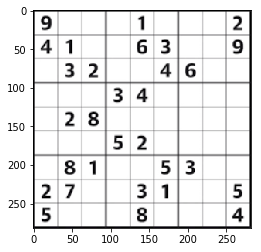

In [25]:
print(np.reshape(predicted_numbers*np.array(nums),(9,9)))
plt.show()
plt.imshow(sudoku)
plt.show()